In [1]:
project_dir = "/Users/joannarownicka/software/vad"
os.chdir(project_dir)

In [2]:
import numpy as np
import os
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from lhotse import LilcomFilesWriter

from lhotse.features import Fbank, FeatureSetBuilder
from lhotse.cut import CutSet, SupervisionSet
from lhotse.dataset.sampling import SingleCutSampler, BucketingSampler
from lhotse.dataset.vad import VadDataset

from torch.utils.data import DataLoader

from preprocessing import prepare_vad_dataset
from inference.postprocess import smooth_predictions
from models.dnn import DNN

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
root_dir = Path('evaluation/data')
corpus_dir = root_dir / 'vad_data/'
output_dir = root_dir / 'vad_data_nb/'

In [4]:
cuts = CutSet.from_json(output_dir / 'cuts_80.json.gz')
cuts.describe()

Cuts count: 957
Total duration (hours): 3.3
Speech duration (hours): 2.6 (80.6%)
***
Duration statistics (seconds):
mean    12.3
std      3.9
min      1.4
25%     11.1
50%     13.9
75%     15.1
max     17.2
dtype: float64


In [5]:
# Shuffle data but keep seed fixed, split into 80/10/10
#cuts_train, cuts_dev_eval = train_test_split(cuts, train_size=0.8, random_state=0)
#cuts_dev, cuts_eval = train_test_split(cuts_dev_eval, train_size=0.5, random_state=0)

cuts = cuts.shuffle()
vad_manifests = prepare_vad_dataset.prepare_vad_dataset(corpus_dir, output_dir)

train_ratio = 0.8

num_total = len(vad_manifests["supervisions"])
stop_train_idx = int(np.floor(num_total * train_ratio))
stop_dev_idx = int((num_total - stop_train_idx) // 2 + stop_train_idx)

train_ids, dev_ids, eval_ids = [], [], []
counter = 0
for sup_seg in vad_manifests["supervisions"]:
    id = sup_seg.to_dict()["id"]
    if counter < stop_train_idx:
        train_ids.append(id)
    elif counter < stop_dev_idx:
        dev_ids.append(id)
    else:
        eval_ids.append(id)
    counter += 1

assert train_ids[-1] != dev_ids[0]
assert dev_ids[-1] != eval_ids[0]

cuts_train = cuts.subset(supervision_ids=train_ids)
cuts_dev = cuts.subset(supervision_ids=dev_ids)
cuts_eval = cuts.subset(supervision_ids=eval_ids)

cuts_train.describe()
cuts_dev.describe()
cuts_eval.describe()


Cuts count: 766
Total duration (hours): 2.6
Speech duration (hours): 2.1 (80.6%)
***
Duration statistics (seconds):
mean    12.4
std      3.9
min      1.6
25%     11.2
50%     13.9
75%     15.1
max     16.9
dtype: float64
Cuts count: 95
Total duration (hours): 0.3
Speech duration (hours): 0.3 (79.9%)
***
Duration statistics (seconds):
mean    12.4
std      4.1
min      1.4
25%     11.3
50%     13.9
75%     15.1
max     17.2
dtype: float64
Cuts count: 98
Total duration (hours): 0.3
Speech duration (hours): 0.3 (79.4%)
***
Duration statistics (seconds):
mean    12.2
std      4.0
min      2.1
25%      9.5
50%     13.8
75%     15.1
max     16.4
dtype: float64


In [16]:
vad_dataset = VadDataset()

train_sampler = SingleCutSampler(cuts_train, shuffle=False, max_duration=300)
dev_sampler = SingleCutSampler(cuts_dev, shuffle=False, max_duration=300)
eval_sampler = SingleCutSampler(cuts_eval, shuffle=False, max_duration=300)

train_dloader = DataLoader(vad_dataset, sampler=train_sampler, batch_size=None)
dev_dloader = DataLoader(vad_dataset, sampler=dev_sampler, batch_size=None)
eval_dloader = DataLoader(vad_dataset, sampler=eval_sampler, batch_size=None)

cut_ids = next(iter(dev_sampler))
sample = vad_dataset[cut_ids]

In [49]:
learning_rate = 1e-4
weight_decay = 1e-4

model_id = "dnn_ce_fbank80_ignoreindex"
input_size = sample['inputs'][0].shape[1]
log_dir = Path('storage/models') / model_id

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DNN(input_size=input_size, hidden_size=256, num_classes=2).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=-100)

#optim = torch.optim.Adam(model.parameters())
#                       lr=learning_rate, weight_decay=weight_decay)
                        
optim = torch.optim.SGD(model.parameters(), lr=learning_rate,
                        weight_decay=weight_decay)

def binary_acc(y_pred, y_test): 
    
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    
    pred_vals = [ float(np.argmax(item)) for item in y_pred_tag.detach() ]
    labels = [ float(item) for item in y_test.detach() ]

    keep_indexes = []
    for idx, label in enumerate(labels):
        if label != float(-100):
            keep_indexes.append(idx)

    pred_vals = [pred_vals[i] for i in keep_indexes]
    labels = [labels[i] for i in keep_indexes]

    correct_results_sum = sum(a == b for a, b in zip(pred_vals, labels))
    acc = correct_results_sum / len(labels)
    acc = np.round(acc * 100)

    return acc, pred_vals, labels


train_acc = []
valid_acc = []
for epoch in range(15):
    # training
    acc = []
    model.train()
    train_dloader.sampler.set_epoch(epoch)

    for batch_idx, data in enumerate(train_dloader):

        inputs = data["inputs"].reshape(-1,input_size)
        targets = data["is_voice"].reshape(-1,1).view(-1)
                
        out = model(inputs.to(device))
        model_acc, _, _ = binary_acc(out, targets.unsqueeze(1).to(device))

        loss = criterion(out, targets.long()) #ce
        
        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx} => loss {loss}')
        optim.zero_grad()
        loss.backward()
        acc.append(model_acc)
        norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optim.step()
        t_r = loss.item()
        
    train_acc.append(np.mean(acc))

    # validation
    acc = []
    model.eval()
    for data in dev_dloader:
        inputs = data["inputs"].reshape(-1,input_size)
        targets = data["is_voice"].reshape(-1,1).view(-1)
        out = model(inputs.to(device))
        model_acc, _, _ = binary_acc(out, targets.unsqueeze(1).to(device))
        acc.append(model_acc)
    valid_acc.append(np.mean(acc))
    print(f"epoch: {epoch}, train acc: {train_acc[-1]:.3f}, dev acc: {valid_acc[-1]:.3f}, loss:{t_r:.3f}")
    torch.save({'epoch': epoch + 1, 'state_dict': model.state_dict(),
        'optimizer': optim.state_dict()},
        f'{log_dir}/checkpoint_{epoch}.pth')
                    

Batch 0 => loss 0.7127519845962524
Batch 10 => loss 0.6825496554374695
Batch 20 => loss 0.6679540872573853
Batch 30 => loss 0.641040563583374
epoch: 0, train acc: 36.697, dev acc: 34.750, loss:0.662
Batch 0 => loss 0.6367776393890381
Batch 10 => loss 0.6134581565856934
Batch 20 => loss 0.5999336838722229
Batch 30 => loss 0.5827968716621399
epoch: 1, train acc: 44.212, dev acc: 47.500, loss:0.603
Batch 0 => loss 0.5782796740531921
Batch 10 => loss 0.562932014465332
Batch 20 => loss 0.5495798587799072
Batch 30 => loss 0.5403707027435303
epoch: 2, train acc: 52.000, dev acc: 55.500, loss:0.561
Batch 0 => loss 0.5355778932571411
Batch 10 => loss 0.5253332257270813
Batch 20 => loss 0.5119454264640808
Batch 30 => loss 0.5082299709320068
epoch: 3, train acc: 59.061, dev acc: 62.000, loss:0.528
Batch 0 => loss 0.5028893947601318
Batch 10 => loss 0.49604931473731995
Batch 20 => loss 0.4823342263698578
Batch 30 => loss 0.4822128713130951
epoch: 4, train acc: 65.091, dev acc: 67.750, loss:0.502
B

In [51]:
pred_list = []
gold_list = []

model.eval()
with torch.no_grad():
    for data in eval_dloader:
        
        inputs_eval = data["inputs"].reshape(-1,input_size)
        targets_eval = data["is_voice"].reshape(-1,1).view(-1)

        out = model(inputs_eval.to(device))
        model_acc, predictions, labels = binary_acc(out, targets_eval.unsqueeze(1).to(device))

        pred_list.extend(predictions)
        gold_list.extend(labels)

In [65]:
smoothed_pred_list = smooth_predictions(
                pred_list, \
                smooth_num_frames=3, \
                hangover=True, \
                min_speech_frames=10)

In [66]:
print(set(gold_list))
print(set(smoothed_pred_list))

print(confusion_matrix(gold_list, smoothed_pred_list))
print(classification_report(gold_list, smoothed_pred_list))

{0.0, 1.0}
{0.0, 1.0}
[[19965  4701]
 [ 6520 88499]]
              precision    recall  f1-score   support

         0.0       0.75      0.81      0.78     24666
         1.0       0.95      0.93      0.94     95019

    accuracy                           0.91    119685
   macro avg       0.85      0.87      0.86    119685
weighted avg       0.91      0.91      0.91    119685



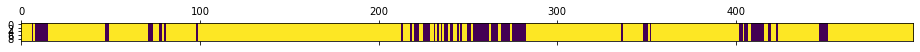

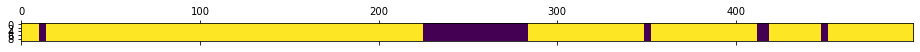

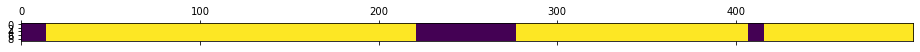

In [71]:
label_height = 10
num_frames = 500

assert num_frames <= len(pred_list)

vad_label = torch.stack([torch.Tensor(pred_list[:num_frames]) for i in range(label_height)]).reshape(label_height, num_frames)
plt.matshow(vad_label)

vad_label = torch.stack([torch.Tensor(smoothed_pred_list[:num_frames]) for i in range(label_height)]).reshape(label_height, num_frames)
plt.matshow(vad_label)

vad_label = torch.stack([torch.Tensor(gold_list[:num_frames]) for i in range(label_height)]).reshape(label_height, num_frames)
plt.matshow(vad_label)
